# Data Science Assignment 3: Analyzing Bank Data
<b>Ryan Sitton</b>
<br>DSE 511
<br>October 12, 2020
<br>In this notebook, I am evaluating a 20 year old set of data from a bank, about a set of accounts.

In [1]:
import sqlite3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
conn = sqlite3.connect('financial.db')
cur = conn.cursor()
 #I needed to find out the tables that were in the data set, so the next command does this:
print (cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall())

[('account',), ('card',), ('client',), ('disp',), ('district',), ('loan',), ('order',), ('trans',)]


In [3]:
 # Knowing the table names, I created panda tables for each of the tables in the dataset...
df_account = pd.read_sql_query("SELECT * FROM account", conn)
df_card = pd.read_sql_query("SELECT * FROM card", conn)
df_client = pd.read_sql_query("SELECT * FROM client", conn)
df_disp = pd.read_sql_query("SELECT * FROM disp", conn)
df_district = pd.read_sql_query("SELECT * FROM district", conn)
df_loan = pd.read_sql_query("SELECT * FROM loan", conn)
df_trans = pd.read_sql_query("SELECT * FROM trans", conn)
# df_order = pd.read_sql_query("SELECT * FROM order", conn) <- for some reason this one wouldnt work???

In [4]:
 # Now I am going the through the tables one by one looking at the data in each one of them to find connections...
df_trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,None,None,NaN
1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,None,AB,41403269.0
2,6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,None,AB,41403269.0
3,7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,None,AB,41403269.0
4,8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,None,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...
1056315,3682983,10451,1998-08-31,PRIJEM,None,62,17300,UROK,None,NaN
1056316,3682984,10451,1998-09-30,PRIJEM,None,49,13442,UROK,None,NaN
1056317,3682985,10451,1998-10-31,PRIJEM,None,34,10118,UROK,None,NaN
1056318,3682986,10451,1998-11-30,PRIJEM,None,26,8398,UROK,None,NaN


# Discussion
I continually typed in the various table names to give me insight on what variables where in which tables. This data is hard to get a handle on, because there is so much data, and most of it appeared to be fairly "transactional". The tables contain mostly typical banking information, such as account identification, basic client demographics, information about loans (size and status), specific transaction information from accounts, and some summary information on the districts in which people lived.

The "trans" table actually has the most data in it, but it would require some more complicated anlaysis, like trending account balance over time to make that data useful. I tried to envision which data would be interesting to a bank. Perhaps something that would show savings or spending trends, or loan disposition indicators. These tables/columns appeared to have the data to do this work:
   - client: client_id, Gender, Age, District
   - district: disctrict_id and A2, A3 (names)
   - loan: loan_id, account_id, amount, status
   - disp: has both client_id and account_id
    
I noted that the identifiers common in mutiple tables were: account_id, district_id, and client_id. These appear to be the primary connections between the tables.

Given my abilities at this point, it seems like it might be interesting to estblish some prediction of "status" using demographic and account information. Do do this, I need to combine the CLIENT, DISP, and LOAN tables to view this information together. This seems a bit counterproductive, as I am bascially turning a database into a flat file, but it seems to be the easiest way to evaluate the trends in the data.

In [5]:
df_clientmerge = df_client.merge(df_disp)
df_clientmerge

,client_id,gender,birth_date,district_id,disp_id,account_id,type
0,1,F,1970-12-13,18,1,1,OWNER
1,2,M,1945-02-04,1,2,2,OWNER
2,3,F,1940-10-09,1,3,2,DISPONENT
3,4,M,1956-12-01,5,4,3,OWNER
4,5,F,1960-07-03,5,5,3,DISPONENT
...,...,...,...,...,...,...,...
5364,13955,F,1945-10-30,1,13647,11349,OWNER
5365,13956,M,1943-04-06,1,13648,11349,DISPONENT
5366,13968,M,1968-04-13,61,13660,11359,OWNER
5367,13971,F,1962-10-19,67,13663,11362,OWNER


In [6]:
df_cl = df_clientmerge.merge(df_loan)
df_cl

,client_id,gender,birth_date,district_id,disp_id,account_id,type,loan_id,date,amount,duration,payments,status
0,2,M,1945-02-04,1,2,2,OWNER,4959,1994-01-05,80952,24,3373,A
1,3,F,1940-10-09,1,3,2,DISPONENT,4959,1994-01-05,80952,24,3373,A
2,25,F,1939-04-23,21,25,19,OWNER,4961,1996-04-29,30276,12,2523,B
3,31,M,1962-02-09,68,31,25,OWNER,4962,1997-12-08,30276,12,2523,A
4,45,M,1952-08-26,20,45,37,OWNER,4967,1998-10-14,318480,60,5308,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,13924,F,1952-09-09,54,13616,11328,OWNER,7295,1998-07-18,280440,60,4674,C
823,13955,F,1945-10-30,1,13647,11349,OWNER,7304,1995-10-29,419880,60,6998,C
824,13956,M,1943-04-06,1,13648,11349,DISPONENT,7304,1995-10-29,419880,60,6998,C
825,13968,M,1968-04-13,61,13660,11359,OWNER,7305,1996-08-06,54024,12,4502,A


In [7]:
# df_account.to_csv (r'C:\Users\Ron\Desktop\account_data.csv', index = False)
# Saving this command here in case I want to export tables to excel to view them more easily and do some analysis

# Analysis
With the "df_cl" table in place, I am going to explore the "loan status" information, first by running a historgram to see the relative amount of loans in a given status.

Text(0.5, 1.0, 'Figure 1: Loan Status Distribution')

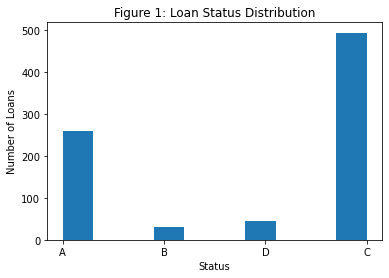

In [8]:
plt.hist(df_cl["status"])
plt.ylabel("Number of Loans")
plt.xlabel("Status")
plt.title("Figure 1: Loan Status Distribution")

From the Explanation Website:
- 'A' stands for contract finished, no problems
- 'B' stands for contract finished, loan not payed
- 'C' stands for running contract, OK so far
- 'D' stands for running contract, client in debt

Now I will build a scatter plot to compare the age, gender, and status of the loans, to look for any correlation.

In [9]:
df_cl["gender_color"]=df_cl["gender"].replace({"M":"red", "F":"blue"})
df_cl["gender_color"]

0       red
1      blue
2      blue
3       red
4       red
       ... 
822    blue
823    blue
824     red
825     red
826    blue
Name: gender_color, Length: 827, dtype: object

In [10]:
df_cl["birth_date"]=pd.to_datetime(df_cl["birth_date"])
# I recognized that the birth date was an object, and ran this to convert it to a date format.
# I was then going to convert to age, but decided that was not useful in my further analyses.
# df_clientloan["age"]=  (not using this right now)

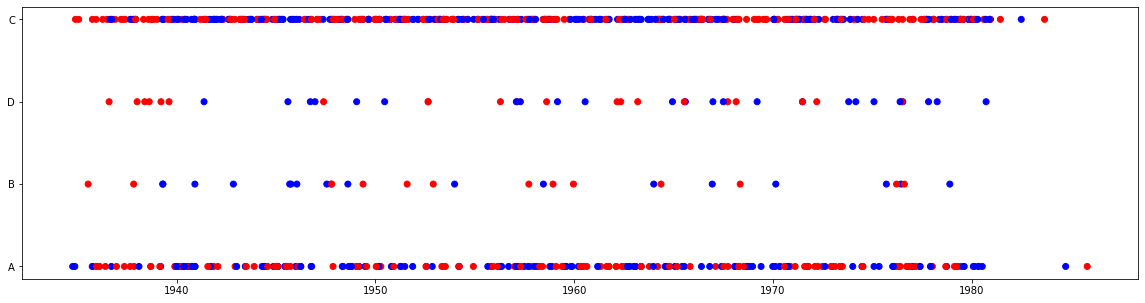

In [11]:
plt.figure(figsize=(20,5))
plt.scatter(df_cl["birth_date"], df_cl["status"], c=df_cl["gender_color"])

Apparently there is no correlation (or none that is very interesting) in the loan status.  The distribution here seems fairly even between male and female, and evenly spread over age.  The only outlying data here is that early on (1930's) there was a low ratio of women to men borrowing money.  Not surprising.

Since this analysis wasn't very interesting, I am going to do one more: Comparing the loan amounts on a per district basis.  The district information is pretty interesting, given the income, unemployment, number of entrepreneurs, etc.  Perhaps it will be interesting to examine any correlation to loan amounts.

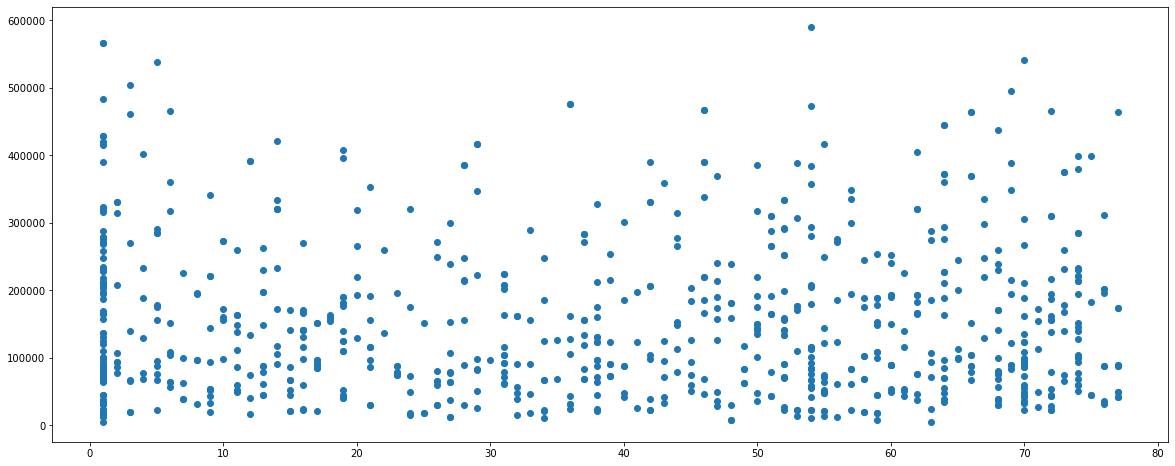

In [12]:
plt.figure(figsize=(20,8))
plt.scatter(df_cl["district_id"], df_cl["amount"])

Once again, there appears to be little interesting correlations in amount, however, number of loans may be interesting. The last thing I will look into is the relationship between number of loans and population.  I start with a histogram, then below it plot a bar chart with the population levels.

<BarContainer object of 77 artists>

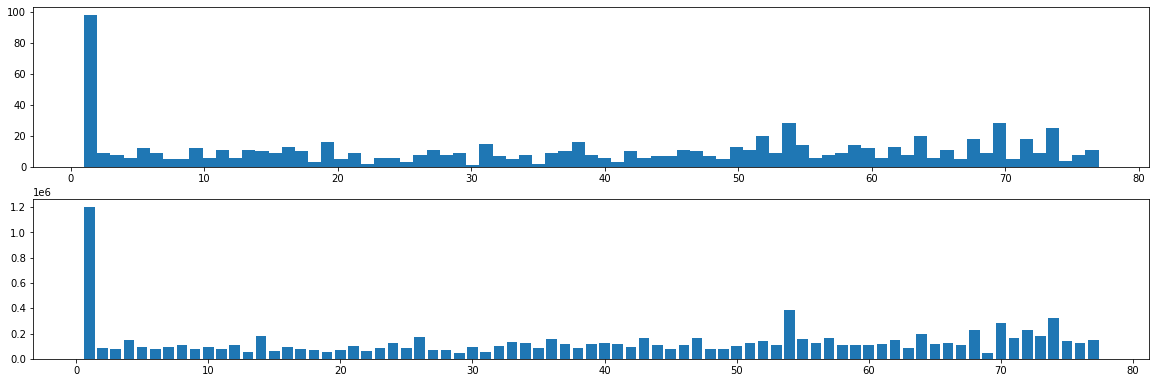

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.hist(df_cl["district_id"],77)
plt.subplot(312)
plt.bar(df_district["district_id"],df_district["A4"])

This polt has resulted in nothing else interesting. While there are a few areas where it appears that the loan to population ratio varies, in general it seems that the loan to people ratio is fairly even across the country.  Therefore, it does not appear that there is anything worth digging into in more detail.

# Conclusion
From the anlyses I have run, there does not appear to be any clever insights popping out of this data. In particular, I have not found any insights that would be interesting to the bank, such as borrowing behavior or loan risk.  However, it seems as though I need to run a more complicated anlysis that I do not know how to do... yet. 

As to additional data, I cannot think of any that I would like to get.  Once again, I am more interested in doing additional anlysis on the data that is here, requiring additional skills.  For example, if I could perform a multi-variable analysis, in which I compared crime rates, income rates, age, loan amount, and account trends over time, it may be possible to identify risk profiles in different age groups. To do this, I need to take the "transaction" table and somehow break it up into trends per account, looking for spend rates, negative balances, maximum balances, etc.  If we could show a correlation between all of these, it would not only be interesting to the bank, but interesting to government leaders as they try to establish economic predictions for specific regions.

In conclusion, the next step is to improve my python development capabilities. With additional anlsyses of the data we have, I can then identify which additional data we need.